# Hands on Machine Learning with Scikit-Learn and Tensorflow

## Chapter 3: Classification

### Notebook by: Arunava

<hr/>
<hr/>
<hr/>

In [16]:
# Ignoring Warnings
import warnings

def warn(*args, **kwargs):
    pass
warnings.warn = warn

## MNIST
<hr/>

In [17]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [18]:
X, y = mnist['data'], mnist['target']
print (X.shape)
print (y.shape)

(70000, 784)
(70000,)


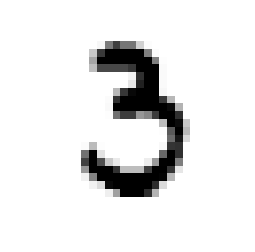

Label:  3.0


In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[23456].reshape(28, 28)
plt.imshow(some_digit, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print ('Label: ', y[23456])

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [21]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

## Training a Binary Classifier
<hr/>

In [22]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [23]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)
sgd_clf.predict(some_digit.ravel().reshape(1, -1))

array([ True])

## Performance Measures
<hr/>

Implementing cross-validation from scratch

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

i = 1

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    
    X_train_f = X_train[train_index]
    y_train_f = y_train_3[train_index]
    
    X_test_f = X_train[test_index]
    y_test_f = y_train_3[test_index]
    
    clone_clf.fit(X_train_f, y_train_f)
    pred = clone_clf.predict(X_test_f)
    
    n_correct = sum(pred == y_test_f)
    acc = n_correct/len(X_test_f)
    print ('Accuracy - Iteration', i, ' :', acc)
    
    i += 1

Accuracy - Iteration 1  : 0.9596520173991301
Accuracy - Iteration 2  : 0.96085
Accuracy - Iteration 3  : 0.9664483224161208


Using `cross_val_score()` along with `sgd_clf`

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.95965202, 0.96085   , 0.96644832])

Building a dumb classifier that predicts everything in the 'not 3' class

In [26]:
from sklearn.base import BaseEstimator

class Never3Clasifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)

In [27]:
never_3_clf = Never3Clasifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.89655, 0.90105, 0.89585])

~90% Accuaracy!

This is simply because about 10% of the classes are `3` and rest are `not_3`.

Also, if you simply predict not `3` always then you are bound to get accuracy of `90%` all the time as only `10%` of the examples are `3`.

This is the reason that `accuracy` is not a very good measure of how good a classifier really is. (Especially in cases of skewed datasets where some classes are much more frequent than others)
<hr/>

## Confusion Matrix

A general idea is to count the number of times instances of class A were classified as class B and class A i.e. correct predictions and incorrect predictions.

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
confusion_matrix(y_train_pred, y_train_3)

array([[52807,  1199],
       [ 1062,  4932]])

In the confusion matrix, each **row represents an actual class** while each **columnrepresents a predicted class**.

1, 1 -> true negetives

1, 2 -> false positives

2, 1 -> false negetives

2, 2 -> true positives

A perfect classifier would have only the true positives and true negetives

In [29]:
confusion_matrix(y_train_3, y_train_3)

array([[53869,     0],
       [    0,  6131]])

A more consise metric would be look at the classifier's precision which is the accuary of the positive predictions.


\begin{align}
precision = \frac{TP}{TP+FP}
\end{align}

where, _TP_ is the number of true positives and _FP_ is the number of false positives

A trivial way to have a perfect precision is to make one single positive prediction and ensure it is correct (`precision` = `1/1` = `100%`)

This would not be very useful.

So, precision is typically used along with another metric name _recall_ (sensitivity or true positive rate (TPR)) -> this is the ratio of positive instances that are correctly detected by the classifier

\begin{align}
recall = \frac{TP}{TP+FN}
\end{align}

where _FN_ is false negetives

<hr/>

### Precision and Recall

In [31]:
from sklearn.metrics import precision_score, recall_score

print ('Precision score:', precision_score(y_train_3, y_train_pred))
print ('Recall score:', recall_score(y_train_3, y_train_pred))

Precision score: 0.8228228228228228
Recall score: 0.8044364703963465


Now the 3-detector doesn't seem as good as previous.

As you can see it is correct only `82%` of the time (precision score)

and, it detects only `80%` of the `5`s

We often combine precision and recall into a single metric called the _F1 score_.

It calculates the harmonic mean which gives more weight to the low values (irrespective to regular mean where all values are treated equally)

\begin{align}
F1 = \frac{TP}{TP+\frac{FN+FP}{2}}
\end{align}

Okay, lets now compute the f1 score

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_3, y_train_pred)

0.8135257731958762

f1 score favours classifiers that have similar precision and recall. This is not always the case as in some context you mostly care about the precision and in other contexts you care about the recall.

Increasing precision reduces recall and vice versa. This is called **precision/recall tradeoff**.

<hr/>

## Precision/Recall Tradeoff

In the SDGClassifier you cannot set the threshold directly but you can get the decision scores which is calcualted for each instance.

Raising the threshold increases the precision and decreases the recall

Lowering the threshold decreases the precision and increases the recall.

In [45]:
y_scores = sgd_clf.decision_function([some_digit.ravel()])
print ('y_scores: ', y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print ('y_some_digit_pred: ', y_some_digit_pred)

y_scores:  [226281.84757981]
y_some_digit_pred:  [ True]


Since, the threshold is set to `0` every instance is classified as `5` and thus whatever the score is the classifier would return `True`.

Let's raise the threshold.

In [46]:
threshold = 230000
y_some_digit_pred = (y_scores > threshold)
print ('y_some_digit_pred: ', y_some_digit_pred)

y_some_digit_pred:  [False]


So, how can we decide what threshold to use?

Let's get the scores of all instances using `cross_val_predict()`.

Note: Since we need to get the scores we need to pass `method='decision_function'` to `cross_val_predict()`

In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method='decision_function')

With all the scores we can now calculate `precision` and `recall` for thresholds.

In [48]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

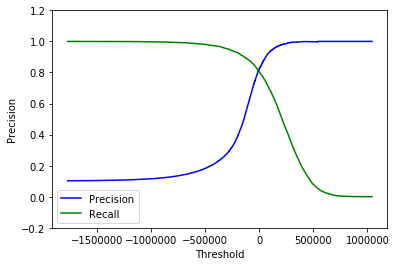

In [64]:
def plot_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.legend()
    plt.ylim([-0.2, 1.2])
    
plot_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

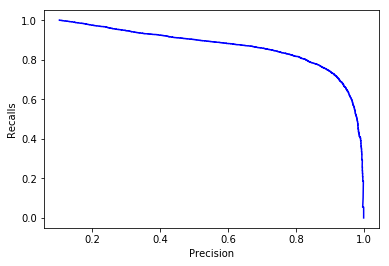

In [73]:
plt.plot(precisions, recalls, 'b-')
plt.xlabel('Precision')
plt.ylabel('Recalls')
plt.show()

If we closely look at the precison vs threshold graph and find that to get a `~90%` precision we need to use a `threshold` of `70000` then we can just simply make the predictions as the following without the use of the `predict()`.

In [74]:
y_train_90_pred = (y_scores > 70000)
print ('Precision score:', precision_score(y_train_3, y_train_90_pred))
print ('Recall score:', recall_score(y_train_3, y_train_90_pred))

Precision score: 0.9124820659971306
Recall score: 0.726145816343174


Great! we now have a `91%` precision classifier. It's pretty easy to create a classifier with any precision.

But, it comes with a cost, look at the recall score!

## The ROC Curve